In [25]:
import torch
import torchvision
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.nn.functional as fun
import pandas as pd
from torch.optim import AdamW, Adam
from sklearn.model_selection import StratifiedKFold
from data import get_data
(x_train, y_train, x_test, y_test) = get_data()

In [26]:
def df_to_tensor(df: pd.DataFrame):
    return torch.from_numpy(df.values).float()

# convert classes to numerical data
def to_numerical(df: pd.Series, positive_class = 'g'):
    new = df.copy()
    for i, v in enumerate(new.values):
        if v == positive_class:
            new.iloc[i] = 1.
        else:
            new.iloc[i] = 0.
    return new.astype(float)

x_train = df_to_tensor(x_train)
x_test = df_to_tensor(x_test)
y_train = df_to_tensor(to_numerical(y_train))
y_test = df_to_tensor(to_numerical(y_test))

In [27]:
# loaders
BATCH_SIZE = 64
def loaders(x_train,y_train,x_test,y_test,batch_size=BATCH_SIZE):
    trainset = DataLoader(TensorDataset(x_train,y_train), batch_size=BATCH_SIZE, shuffle=True)
    testset = DataLoader(TensorDataset(x_test, y_test), batch_size=BATCH_SIZE, shuffle=True)
    return trainset, testset

In [67]:
EPOCHS = 5

def train(loader:DataLoader, model:nn.Module, optimizer, epochs = EPOCHS):
    model.train()
    for epoch in range(epochs):
        for data in loader:
            X, y = data
            optimizer.zero_grad()
            output = model(X.view(-1,10))
            loss = fun.binary_cross_entropy(output.view(y.shape), y)
            loss.backward()
            optimizer.step()
        print(f"epoch {epoch+1} / {epochs}\t loss {loss}")

In [29]:
def get_accuracy_loss(test_loader:DataLoader, model:nn.Module):
    model.eval()
    correct = 0
    total = 0
    loss = 0
    with torch.no_grad():
        for data in test_loader:
            X, y = data
            output = model(X)
            loss += fun.binary_cross_entropy(output.view(y.shape),y,reduction='sum').item()
            for idx, i in enumerate(output):
                i = 1 if i >= 0.5 else 0
                if  i == y[idx]:
                    correct += 1
                total += 1
    loss /= len(test_loader.dataset)
    return round(correct / total,3), round(loss,4)

In [30]:
# model
class Model(nn.Module):
    def __init__(self, l1_nodes, l2_nodes, input_size = 10):
        super().__init__()
        self.l1 = nn.Linear(input_size, l1_nodes)
        self.l2 = nn.Linear(l1_nodes, l2_nodes)
        self.l3 = nn.Linear(l2_nodes, 1)

    def forward(self, x):
        x = fun.relu(self.l1(x))
        x = fun.relu(self.l2(x))

        x = torch.sigmoid(self.l3(x)) # TODO: sigmoid or no?
        return x


def reset_weights(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        m.reset_parameters()


In [55]:
# kfolds
def k_folds_validation(features_train,labels_train,l1_nodes, l2_nodes, lr = 5e-4, epochs = EPOCHS, batch_size = BATCH_SIZE):
    skf = StratifiedKFold(n_splits=10, shuffle=True)
    model = Model(l1_nodes,l2_nodes)
    optimizer = Adam(model.parameters(),lr = lr)
    avg_accuracy = 0
    for fold, (train_idx, val_idx) in enumerate(skf.split(features_train, labels_train)):
        train_fold_loader, validate_fold_loader = loaders(
            features_train[train_idx],
            labels_train[train_idx],
            features_train[val_idx],
            labels_train[val_idx],
            batch_size=batch_size
            )
        model.apply(reset_weights)
        #print(f"--------------------------------- Fold {fold + 1} / {skf.get_n_splits()} ---------------------------------")
        train(train_fold_loader, model,optimizer, epochs = epochs)
        accuracy, loss = get_accuracy_loss(validate_fold_loader, model)
        avg_accuracy = (avg_accuracy + accuracy) / 2
        #print(f"\n Validation:")
        #print(f"Accuracy = {accuracy}, Loss = {loss}")
    return avg_accuracy

In [38]:
avg_accuracy = k_folds_validation(x_train, y_train, 20,20)
print(f"Average Accuracy for {20,20} nn = {round(avg_accuracy,4)}")

--------------------------------- Fold 1 / 10 ---------------------------------

 Validation:
Accuracy = 0.72, Loss = 0.5316
--------------------------------- Fold 2 / 10 ---------------------------------

 Validation:
Accuracy = 0.759, Loss = 0.487
--------------------------------- Fold 3 / 10 ---------------------------------

 Validation:
Accuracy = 0.745, Loss = 0.49
--------------------------------- Fold 4 / 10 ---------------------------------

 Validation:
Accuracy = 0.783, Loss = 0.4661
--------------------------------- Fold 5 / 10 ---------------------------------

 Validation:
Accuracy = 0.764, Loss = 0.4836
--------------------------------- Fold 6 / 10 ---------------------------------

 Validation:
Accuracy = 0.77, Loss = 0.4721
--------------------------------- Fold 7 / 10 ---------------------------------

 Validation:
Accuracy = 0.752, Loss = 0.4834
--------------------------------- Fold 8 / 10 ---------------------------------

 Validation:
Accuracy = 0.752, Loss = 0.50

In [39]:
from matplotlib import pyplot as plt

--------------------------------- Fold 1 / 10 ---------------------------------

 Validation:
Accuracy = 0.716, Loss = 0.5277
--------------------------------- Fold 2 / 10 ---------------------------------

 Validation:
Accuracy = 0.768, Loss = 0.4982
--------------------------------- Fold 3 / 10 ---------------------------------

 Validation:
Accuracy = 0.752, Loss = 0.4927
--------------------------------- Fold 4 / 10 ---------------------------------

 Validation:
Accuracy = 0.745, Loss = 0.5109
--------------------------------- Fold 5 / 10 ---------------------------------

 Validation:
Accuracy = 0.756, Loss = 0.5152
--------------------------------- Fold 6 / 10 ---------------------------------

 Validation:
Accuracy = 0.745, Loss = 0.5048
--------------------------------- Fold 7 / 10 ---------------------------------

 Validation:
Accuracy = 0.73, Loss = 0.5379
--------------------------------- Fold 8 / 10 ---------------------------------

 Validation:
Accuracy = 0.694, Loss = 

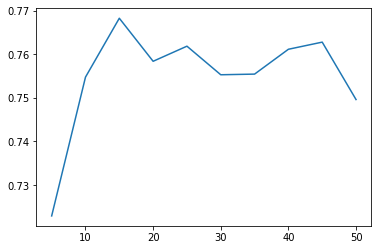

In [40]:
# n2 = 64, iterate for n1 from (5,50), step = 5
l2_nodes = 64
accuracy_array = []
l1_array = range(5,51,5)
for l1_nodes in l1_array:
    accuracy_array.append(k_folds_validation(x_train, y_train,l1_nodes, l2_nodes))

plt.plot(l1_array,accuracy_array)
plt.show()

In [42]:
max_acc = max(accuracy_array)
idx = accuracy_array.index(max_acc)
print(f" max accuracy = {max(accuracy_array)} at l1 = {l1_array[idx]}")

 max accuracy = 0.7682509765625001 at l1 = 15


 max accuracy = 0.76646875 at l2 = 40


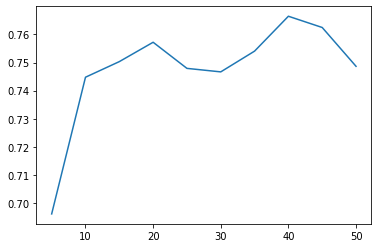

In [44]:
# setting l1 = 15, iterate over l2 (5,50,5)
l1_nodes = 15
accuracy_array = []
l2_array = range(5,51,5)
for l2_nodes in l2_array:
    accuracy_array.append(k_folds_validation(x_train, y_train,l1_nodes, l2_nodes))

max_acc = max(accuracy_array)
idx = accuracy_array.index(max_acc)
print(f" max accuracy = {max(accuracy_array)} at l2 = {l2_array[idx]}")

plt.plot(l2_array,accuracy_array)
plt.show()

Try the above again for a more suitable range

l2 = 35, accuracy = 0.7510107421875001
l2 = 40, accuracy = 0.7441718749999999
l2 = 45, accuracy = 0.7517939453125
l2 = 50, accuracy = 0.761783203125
l2 = 55, accuracy = 0.7244228515625
l2 = 60, accuracy = 0.7552138671875
l2 = 65, accuracy = 0.753125
l2 = 70, accuracy = 0.7564111328125
 max accuracy = 0.761783203125 at l2 = 50


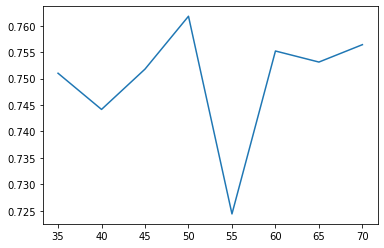

In [45]:
# setting l1 = 15, iterate over l2 (35,70,5)
l1_nodes = 15
accuracy_array = []
l2_array = range(35,71,5)
for l2_nodes in l2_array:
    acc = k_folds_validation(x_train, y_train,l1_nodes, l2_nodes)
    accuracy_array.append(acc)
    print(f"l2 = {l2_nodes}, accuracy = {acc}")

max_acc = max(accuracy_array)
idx = accuracy_array.index(max_acc)
print(f" max accuracy = {max(accuracy_array)} at l2 = {l2_array[idx]}")

plt.plot(l2_array,accuracy_array)
plt.show()

l1 = 10, accuracy = 0.7585244140625
l1 = 11, accuracy = 0.751783203125
l1 = 12, accuracy = 0.7451132812500001
l1 = 13, accuracy = 0.7516025390625
l1 = 14, accuracy = 0.7541044921875
l1 = 15, accuracy = 0.7538486328125
l1 = 16, accuracy = 0.7484794921875
l1 = 17, accuracy = 0.7608896484375001
l1 = 18, accuracy = 0.757056640625
l1 = 19, accuracy = 0.75366796875
l1 = 20, accuracy = 0.7620849609375
 max accuracy = 0.7620849609375 at l1 = 20


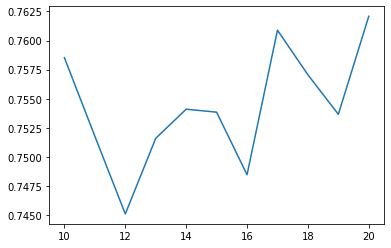

In [48]:
# setting l2 = 50, iterate over l1 (10,20)
l2_nodes = 50
accuracy_array = []
l1_array = range(10,21)
for l1_nodes in l1_array:
    acc = k_folds_validation(x_train, y_train,l1_nodes, l2_nodes)
    accuracy_array.append(acc)
    print(f"l1 = {l1_nodes}, accuracy = {acc}")

max_acc = max(accuracy_array)
idx = accuracy_array.index(max_acc)
print(f" max accuracy = {max(accuracy_array)} at l1 = {l1_array[idx]}")

plt.plot(l1_array,accuracy_array)
plt.show()

In [50]:
max_acc = max(accuracy_array)
idx = accuracy_array.index(max_acc)
print(f" max accuracy = {max(accuracy_array)} at l1 = {l1_array[idx]}")

 max accuracy = 0.7620849609375 at l1 = 20


l2 = 45, accuracy = 0.764458984375
l2 = 46, accuracy = 0.757986328125
l2 = 47, accuracy = 0.7626513671875
l2 = 48, accuracy = 0.7506552734375
l2 = 49, accuracy = 0.7406884765624999
l2 = 50, accuracy = 0.761361328125
l2 = 51, accuracy = 0.760568359375
l2 = 52, accuracy = 0.7538271484375001
l2 = 53, accuracy = 0.7681513671875
l2 = 54, accuracy = 0.75317578125
l2 = 55, accuracy = 0.7555527343749999
 max accuracy = 0.7681513671875 at l2 = 53


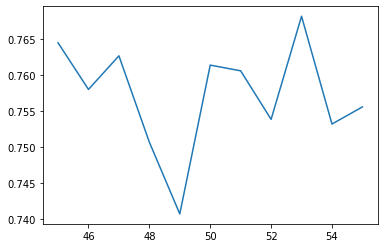

In [51]:
# setting l1 = 20, iterate over l2 (45,55)
l1_nodes = 20
accuracy_array = []
l2_array = range(45,56)
for l2_nodes in l2_array:
    acc = k_folds_validation(x_train, y_train,l1_nodes, l2_nodes)
    accuracy_array.append(acc)
    print(f"l2 = {l2_nodes}, accuracy = {acc}")

max_acc = max(accuracy_array)
idx = accuracy_array.index(max_acc)
print(f" max accuracy = {max(accuracy_array)} at l2 = {l2_array[idx]}")

plt.plot(l2_array,accuracy_array)
plt.show()

Best parameters = 2, 53
try for l1 one more time:

l1 = 10, accuracy = 0.73726171875
l1 = 11, accuracy = 0.7688613281250001
l1 = 12, accuracy = 0.7524199218750001
l1 = 13, accuracy = 0.7678232421875
l1 = 14, accuracy = 0.7580068359375001
l1 = 15, accuracy = 0.7544111328125
l1 = 16, accuracy = 0.7482548828125
l1 = 17, accuracy = 0.7442685546875
l1 = 18, accuracy = 0.7573134765625
l1 = 19, accuracy = 0.7608984375000001
l1 = 20, accuracy = 0.7467802734375
 max accuracy = 0.7688613281250001 at l1 = 11


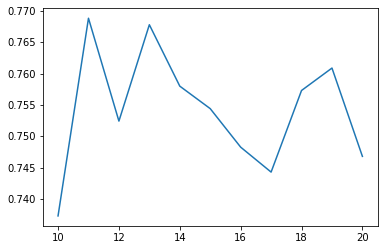

In [52]:
# setting l2 = 50, iterate over l1 (10,20)
l2_nodes = 53
accuracy_array = []
l1_array = range(10,21)
for l1_nodes in l1_array:
    acc = k_folds_validation(x_train, y_train,l1_nodes, l2_nodes)
    accuracy_array.append(acc)
    print(f"l1 = {l1_nodes}, accuracy = {acc}")

max_acc = max(accuracy_array)
idx = accuracy_array.index(max_acc)
print(f" max accuracy = {max(accuracy_array)} at l1 = {l1_array[idx]}")

plt.plot(l1_array,accuracy_array)
plt.show()

best accuracy = 76.89% at an 11, 53 nn.


## Adjusting more hyperparameters 

1. batch size
2. epochs
3. learning rate

lr = 1, accuracy = 0.496927734375
lr = 0.1, accuracy = 0.5002128906250001
lr = 0.01, accuracy = 0.7823261718750001
lr = 0.001, accuracy = 0.7659980468750001
lr = 0.0001, accuracy = 0.7047724609375
lr = 1e-05, accuracy = 0.5707421875
 max accuracy = 0.7823261718750001 at lr = 0.01


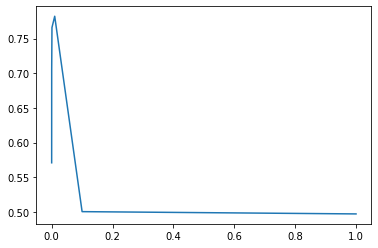

In [56]:
# learning rate alternate epoch

lr_array = [1,0.1,0.01,1e-3,1e-4,1e-5]
accuracy_array = []

l1_nodes = 11
l2_nodes = 53

for lr in lr_array:
    acc = k_folds_validation(x_train, y_train,l1_nodes, l2_nodes,lr=lr)
    accuracy_array.append(acc)
    # print(f"lr = {lr}, accuracy = {acc}")

max_acc = max(accuracy_array)
idx = accuracy_array.index(max_acc)
print(f" max accuracy = {max(accuracy_array)} at lr = {lr_array[idx]}")

plt.plot(lr_array,accuracy_array)
plt.show()

epochs = 5, accuracy = 0.7885068359375
epochs = 15, accuracy = 0.7937714843750001
epochs = 25, accuracy = 0.78025
epochs = 35, accuracy = 0.7841445312499999
epochs = 45, accuracy = 0.7818740234375001
 max accuracy = 0.7937714843750001 at epochs = 15


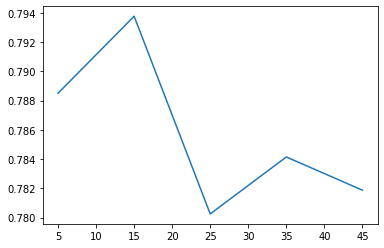

In [57]:
# learning rate alternate epoch

lr = 0.01
epochs_array = range(5,51,10)
accuracy_array = []

l1_nodes = 11
l2_nodes = 53

for epochs in epochs_array:
    acc = k_folds_validation(x_train, y_train,l1_nodes, l2_nodes,lr=lr,epochs=epochs)
    accuracy_array.append(acc)
    print(f"epochs = {epochs}, accuracy = {acc}")

max_acc = max(accuracy_array)
idx = accuracy_array.index(max_acc)
print(f" max accuracy = {max(accuracy_array)} at epochs = {epochs_array[idx]}")

plt.plot(epochs_array,accuracy_array)
plt.show()

In [ ]:
# learning rate alternate epoch
from numpy import arange
lr_array = arange(0.009,0.099,0.001)
accuracy_array = []

epochs = 15
l1_nodes = 11
l2_nodes = 53

for lr in lr_array:
    acc = k_folds_validation(x_train, y_train,l1_nodes, l2_nodes,lr=lr,epochs = epochs)
    accuracy_array.append(acc)
    print(f"lr = {lr}, accuracy = {acc}")

max_acc = max(accuracy_array)
idx = accuracy_array.index(max_acc)
print(f" max accuracy = {max(accuracy_array)} at lr = {lr_array[idx]}")

plt.plot(lr_array,accuracy_array)
plt.show()

 max accuracy = 0.7949873046875 at lr = 0.011999999999999997


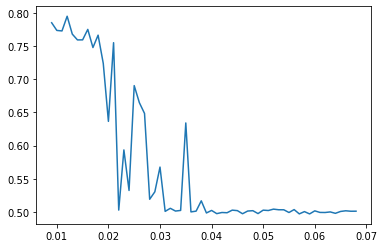

In [60]:
max_acc = max(accuracy_array)
idx = accuracy_array.index(max_acc)
print(f" max accuracy = {max(accuracy_array)} at lr = {lr_array[idx]}")

plt.plot(lr_array[:len(accuracy_array)],accuracy_array)
plt.show()

epochs = 10, accuracy = 0.7758896484375
epochs = 11, accuracy = 0.7854697265625
epochs = 12, accuracy = 0.7756660156249999
epochs = 13, accuracy = 0.7753554687499999
epochs = 14, accuracy = 0.766822265625
epochs = 15, accuracy = 0.773548828125
epochs = 16, accuracy = 0.7707998046875
epochs = 17, accuracy = 0.7870322265625
epochs = 18, accuracy = 0.7865634765625
epochs = 19, accuracy = 0.786837890625
epochs = 20, accuracy = 0.7723876953125
 max accuracy = 0.7870322265625 at epochs = 17


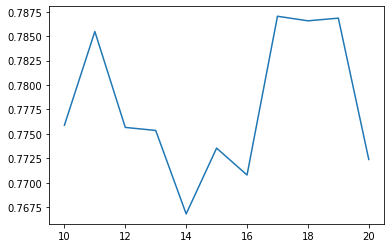

In [61]:
# learning rate alternate epoch

lr = 0.012
epochs_array = range(10,21)
accuracy_array = []

l1_nodes = 11
l2_nodes = 53

for epochs in epochs_array:
    acc = k_folds_validation(x_train, y_train,l1_nodes, l2_nodes,lr=lr,epochs=epochs)
    accuracy_array.append(acc)
    print(f"epochs = {epochs}, accuracy = {acc}")

max_acc = max(accuracy_array)
idx = accuracy_array.index(max_acc)
print(f" max accuracy = {max(accuracy_array)} at epochs = {epochs_array[idx]}")

plt.plot(epochs_array,accuracy_array)
plt.show()

Epochs = 17
Lr = 0.01

batch size = 10, accuracy = 0.7889453125000001
batch size = 110, accuracy = 0.7765029296875
batch size = 210, accuracy = 0.7821669921875001
batch size = 310, accuracy = 0.8049667968750001
batch size = 410, accuracy = 0.7950712890625
batch size = 510, accuracy = 0.7904462890625001
batch size = 610, accuracy = 0.7929140625
batch size = 710, accuracy = 0.7972744140625001
batch size = 810, accuracy = 0.787564453125
batch size = 910, accuracy = 0.797939453125
batch size = 1010, accuracy = 0.7811308593749999
max accuracy = 0.8049667968750001 at batch size = 310


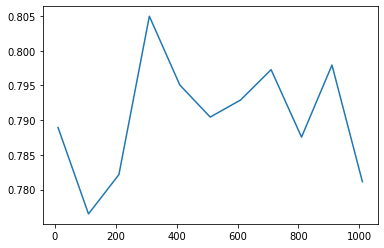

In [63]:
# batch size
batch_arr = range(10,1011,100)
accuracy_array = []

epochs = 17
l1_nodes = 11
l2_nodes = 53
lr = 0.01

for bs in batch_arr:
    acc = k_folds_validation(x_train, y_train,l1_nodes, l2_nodes,lr=lr,epochs = epochs,batch_size=bs)
    accuracy_array.append(acc)
    print(f"batch size = {bs}, accuracy = {acc}")

max_acc = max(accuracy_array)
idx = accuracy_array.index(max_acc)
print(f"max accuracy = {max(accuracy_array)} at batch size = {batch_arr[idx]}")

plt.plot(batch_arr,accuracy_array)
plt.show()

batch size = 200, accuracy = 0.767064453125
batch size = 220, accuracy = 0.790103515625
batch size = 240, accuracy = 0.7782324218750001
batch size = 260, accuracy = 0.7861660156250001
batch size = 280, accuracy = 0.7956308593750001
batch size = 300, accuracy = 0.788302734375
batch size = 320, accuracy = 0.7916767578125
batch size = 340, accuracy = 0.774677734375
batch size = 360, accuracy = 0.7930595703125001
batch size = 380, accuracy = 0.772056640625
batch size = 400, accuracy = 0.7970302734375001
max accuracy = 0.7970302734375001 at batch size = 400


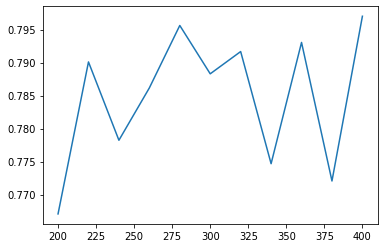

In [64]:
# batch size
batch_arr = range(200,401,20)
accuracy_array = []

epochs = 17
l1_nodes = 11
l2_nodes = 53
lr = 0.01

for bs in batch_arr:
    acc = k_folds_validation(x_train, y_train,l1_nodes, l2_nodes,lr=lr,epochs = epochs,batch_size=bs)
    accuracy_array.append(acc)
    print(f"batch size = {bs}, accuracy = {acc}")

max_acc = max(accuracy_array)
idx = accuracy_array.index(max_acc)
print(f"max accuracy = {max(accuracy_array)} at batch size = {batch_arr[idx]}")

plt.plot(batch_arr,accuracy_array)
plt.show()

All hyper parameters are tuned, now we train the model accordingly

In [77]:
batch_size = 400
epochs = 17
lr = 0.01
l1_nodes = 11
l2_nodes = 53

model = Model(l1_nodes,l2_nodes)
optimizer = Adam(model.parameters(),lr = lr)
avg_accuracy = 0
train_set, test_set = loaders(
    x_train,
    y_train,
    x_test,
    y_test,
    batch_size=batch_size
    )
model.apply(reset_weights)
train(train_set, model,optimizer, epochs = epochs)

accuracy, loss = get_accuracy_loss(test_set, model)
avg_accuracy = (avg_accuracy + accuracy) / 2
print(f"\n Test:")
print(f"Accuracy = {accuracy}, Loss = {loss}")

epoch 1 / 17	 loss 0.5328453183174133
epoch 2 / 17	 loss 0.4402827322483063
epoch 3 / 17	 loss 0.2610189616680145
epoch 4 / 17	 loss 0.29563799500465393
epoch 5 / 17	 loss 0.39467141032218933
epoch 6 / 17	 loss 0.49355563521385193
epoch 7 / 17	 loss 0.6398259401321411
epoch 8 / 17	 loss 0.44741255044937134
epoch 9 / 17	 loss 0.5018904805183411
epoch 10 / 17	 loss 0.2707672715187073
epoch 11 / 17	 loss 0.36441439390182495
epoch 12 / 17	 loss 0.5330716967582703
epoch 13 / 17	 loss 0.14442405104637146
epoch 14 / 17	 loss 0.6592936515808105
epoch 15 / 17	 loss 0.482984334230423
epoch 16 / 17	 loss 0.37954795360565186
epoch 17 / 17	 loss 0.31740519404411316

 Test:
Accuracy = 0.8, Loss = 0.4245


In [85]:
# build confusion matrix
model.eval()
y_pred = model(x_test)
for i, val in enumerate(y_pred):
    if val >= 0.5:
        y_pred[i] = 1
    else:
        y_pred[i] = 0

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score

m = confusion_matrix(y_test, y_pred.detach().numpy())


Accuracy = 0.7996511338151009
Precision = 0.7884899163797344
Recall = 0.8108244815376834
F1 = 0.7995012468827931


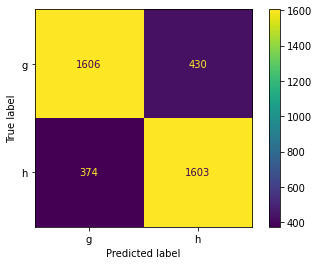

In [88]:
DISPLAY_LABELS = ['g','h']
POS_LABEL = 1

def disp_scores(y_true,y_pred,pos_label = POS_LABEL,display_labels = DISPLAY_LABELS):
    ConfusionMatrixDisplay( confusion_matrix(y_true,y_pred),display_labels=display_labels).plot()
    print("Accuracy =",accuracy_score(y_true,y_pred))
    print("Precision =",precision_score(y_true,y_pred,pos_label=pos_label))
    print("Recall =",recall_score(y_true,y_pred,pos_label=pos_label))
    print("F1 =",f1_score(y_true,y_pred,pos_label=pos_label))

disp_scores(y_test, y_pred.detach().numpy())